In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
df_feature=pd.read_csv('/home/raulherrero/datos-zrive/feature_frame.csv')

Filtramos las cestas con al menos 5 productos

In [4]:
# Filtrar solo las filas donde outcome es 1
df_outcome_1 = df_feature[df_feature['outcome'] == 1]

# Contar el número de productos comprados para cada id de compra
basket_counts = df_outcome_1.groupby('order_id').size()

# Filtrar los ids de compra que tienen al menos 5 productos
basket_ids_at_least_5 = basket_counts[basket_counts >= 5].index

# Filtrar el DataFrame original para obtener las cestas con al menos 5 productos
df_baskets_at_least_5 = df_feature[df_feature['order_id'].isin(basket_ids_at_least_5)]

In [5]:
df_baskets_at_least_5.shape[0]


2163953

In [6]:
df_baskets_at_least_5.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2163953 entries, 0 to 2880547
Data columns (total 27 columns):
 #   Column                            Dtype  
---  ------                            -----  
 0   variant_id                        int64  
 1   product_type                      object 
 2   order_id                          int64  
 3   user_id                           int64  
 4   created_at                        object 
 5   order_date                        object 
 6   user_order_seq                    int64  
 7   outcome                           float64
 8   ordered_before                    float64
 9   abandoned_before                  float64
 10  active_snoozed                    float64
 11  set_as_regular                    float64
 12  normalised_price                  float64
 13  discount_pct                      float64
 14  vendor                            object 
 15  global_popularity                 float64
 16  count_adults                      float64

In [7]:
df_baskets_at_least_5['outcome'].value_counts()

outcome
0.0    2132624
1.0      31329
Name: count, dtype: int64

In [8]:
info_cols= ['variant_id', 'order_id', 'user_id', 'created_at', 'order_date']
label_col='outcome'
features_cols=[col for col in df_feature.columns if col not in info_cols + [label_col]]

categoriacal_cols=['product_type', 'vendor']
binary_cols=['ordered_before', 'abandoned_before', 'active_snoozed', 'set_as_regular']
numerical_cols= [col for col in features_cols if col not in categoriacal_cols + binary_cols]

Codifico las variables con hash en 10 varibles, 10 es un parametro a optimizar

In [10]:
print(hashed_data.shape[0])
print(hashed_categorical_df.shape[0])
print(other_data.shape[0])

NameError: name 'hashed_data' is not defined

In [12]:
from sklearn.feature_extraction import FeatureHasher

# Separar las columnas categóricas y numéricas
other_cols= [col for col in features_cols if col not in categoriacal_cols ]
categorical_data = df_baskets_at_least_5[categoriacal_cols]
other_data = df_baskets_at_least_5[other_cols]

# Crear un objeto FeatureHasher para las variables categóricas
hasher_categorical = FeatureHasher(n_features=30, input_type='string')

# Convertir las columnas categóricas en una matriz dispersa de características hash
hashed_categorical_data = hasher_categorical.fit_transform(categorical_data.values.tolist())

# Crear un DataFrame para las características hash de las variables categóricas
hashed_categorical_df = pd.DataFrame(hashed_categorical_data.toarray())

# Restablecer los índices de los DataFrames antes de la concatenación
hashed_categorical_df.reset_index(drop=True, inplace=True)
other_data.reset_index(drop=True, inplace=True)

# Concatenar las características hash con las variables numéricas
hashed_data = pd.concat([hashed_categorical_df,other_data ], axis=1)

print(hashed_data)

           0    1    2    3    4    5    6    7    8    9  ...  \
0        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
1        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
3        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
4        0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2163948  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2163949  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2163950  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2163951  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   
2163952  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...   

         count_children  count_babies  count_pets  people_ex_baby  \
0                   0.0           0.0         0.0             2.0   
1                   0.0           0.0         0.0             2.0   


Regresion Logistica

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix


# Convertir todos los nombres de columnas a tipo string
hashed_data.columns = hashed_data.columns.astype(str)

X = hashed_data  # Ajusta el nombre de la variable objetivo
y = df_baskets_at_least_5['outcome']  # Ajusta el nombre de la variable objetivo

# Primera división: 70% entrenamiento, 30% restante (validación + prueba)
X_train, X_remaining, y_train, y_remaining = train_test_split(X, y, test_size=0.3, random_state=42)

# Segunda división: dividir los datos restantes en 50% validación y 50% prueba
X_val, X_test, y_val, y_test = train_test_split(X_remaining, y_remaining, test_size=0.5, random_state=42)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Inicializar el clasificador de regresión logística
logistic_regression = LogisticRegression()

# Entrenar el modelo de regresión logística
logistic_regression.fit(X_train_scaled, y_train)



: 

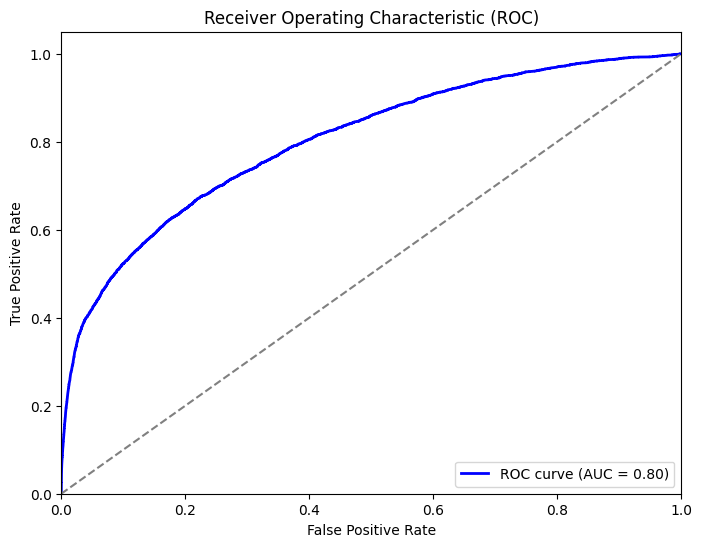

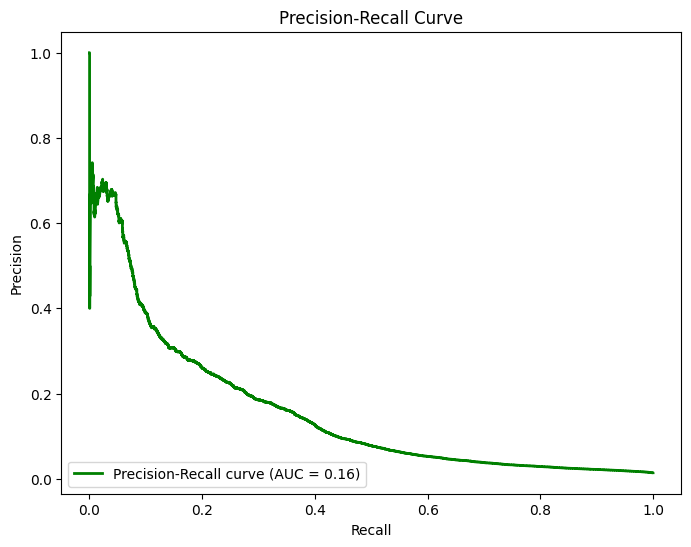

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc

# Obtener las probabilidades de predicción para el conjunto de validación
probs_test = logistic_regression.predict_proba(X_test_scaled)[:, 1]

# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, probs_test)
roc_auc = roc_auc_score(y_test, probs_test)

# Trazar la curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Calcular la curva de precisión y recall
precision, recall, _ = precision_recall_curve(y_test, probs_test)
pr_auc = auc(recall, precision)

# Trazar la curva de precisión y recall
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='green', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
